# Sample Code for MNIST Handwritten Digit Recognition in PyTorch


## pytorch install
conda install torchvision -c pytorch

In [11]:
import numpy as np
import torch
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
SEED = 1
# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)

In [12]:
batch_size_train = 64
batch_size_test = 1000

In [13]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
batch_size=batch_size_test, shuffle=True)

In [14]:
train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

In [15]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

/Users/leowang7267/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1305)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [16]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [17]:
example_data.shape

torch.Size([1000, 1, 28, 28])

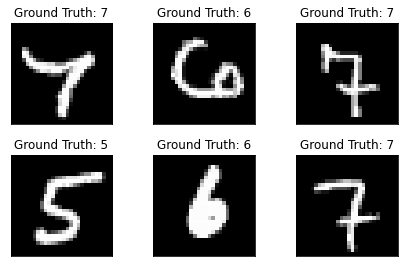

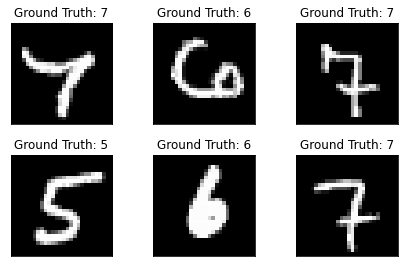

In [18]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

## Model

In [19]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [21]:
# One hidden Layer NN
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc = nn.Linear(784, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = x.view((-1, 784))
        h = F.relu(self.fc(x))
        h = self.fc2(h)
        return F.log_softmax(h)    
    
#initialize the model   
network = Model()
if cuda:
    model.cuda() # CUDA!
#initialize the optimizer   
learning_rate = 0.01
momentum = 0.5
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

## Train and Evaluate

In [22]:
n_epochs = 3##50000/64*3
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
log_interval = 100 ##64*100

In [23]:
def train(epoch):
  network.train()##50000/64
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './results/model.pth')
      torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [24]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [25]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-21-877277782890>:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(h)
/Users/leowang7267/anaconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3063, Accuracy: 935/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309312
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.905449
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.445990
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.090124
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.941089
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.911880
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.732279
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.634407
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.708026
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.633819
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.524470
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.423778
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.374417
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.524601
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.384220
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.468658
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.632019
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.386258
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.510153
Train Epoch: 1 [12160/6

Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.313221
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.548360
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.148886
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.269383
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.201992
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.402785
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.120880
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.259719
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.295944
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.100017
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.250506
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.244520
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.157423
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.125579
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.226348
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.195767
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.130903
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.174180
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.204873
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.123568


## Plot

Text(0, 0.5, 'negative log likelihood loss')

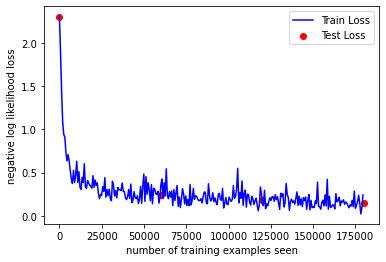

In [26]:
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')